In [2]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation as am
from matplotlib import cm
from scipy.integrate import ode 
from kuramoto import * # import the kuramoto classes from file 
from utils import *
from scipy import stats, optimize

## First, we do some 1D simulations.  

In [10]:
# Set up model parameters 
N_samples = 4
epsilon = 1
gamma = -0.6
sigmas = np.array([0.01, 0.1, 0.3, 1])
mean_omega = 0


# Set up simulation parameters 
Ls = [128]*N_samples
T = 1e4 # total time of the simulation 
n_frames = T # number of time points recorded in the end 
grad = 0.5
grads = [-grad, grad]

data = [] 
omegas = [] 
models = [] 


for (i, sigma) in enumerate(sigmas): 
    # Initialise the model and run the simulation 
    init = np.zeros((Ls[i]))
    model = Kuramoto(epsilon, gamma, sigma, mean_omega, BC='grad', grad=grads)
    model.initialise(Ls[i], T, n_frames, init=init, seed=None) 
    model.evolve() # this runs the simulation, set verbose to True to see output at every time step 
    
    phases = np.copy(model.res[-1]) % (2*np.pi)
    shift(phases)
    data.append(phases)
    omegas.append(model.omegas)
    models.append(model)

100%|██████████| 10000/10000 [02:39<00:00, 62.86it/s]


slope:  0.0957105471468329
slope:  0.21109379958132465
slope:  0.4810707444862442
slope:  0.8585494713887456


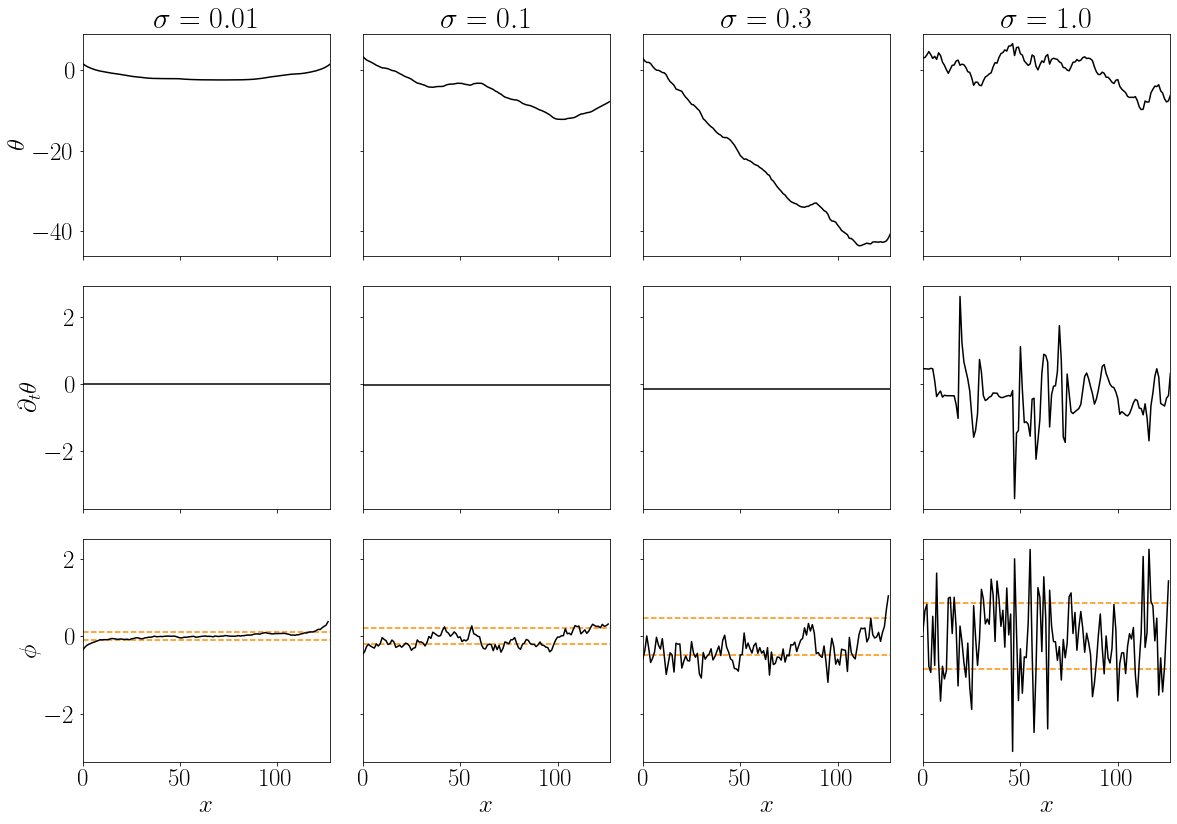

In [8]:
f = 10

plt.rc('text', usetex=True)
plt.rc('font', size=25, family='serif')
fig, axes = plt.subplots(3, len(sigmas[:f]), sharey='row', sharex=True, figsize=(4*len(sigmas[:f])+1, 12))

for (i, sigma) in enumerate(sigmas[:f]):
    axes[0, i].plot(data[i], 'k-')    
    axes[1, i].plot(models[i]._det_rhs(data[i]), 'k-')
    
    v = data[i][1:]-data[i][:-1]
    s = np.sqrt(2*np.mean(1-np.cos(v)))
    axes[2, i].axhline(y=s, color='darkorange', linestyle='--')
    axes[2, i].axhline(y=-s, color='darkorange', linestyle='--')
    axes[2, i].plot(v, 'k-')
    axes[2, i].set_xlabel(r'$x$')
    print('slope: ', s)
    

axes[0, 0].set_ylabel(r'$\theta$')
axes[1, 0].set_ylabel(r'$\partial_t \theta $')
axes[2, 0].set_ylabel(r'$\phi$')
plt.xlim([0, Ls[0]-1])

for i in range(len(sigmas)):
    axes[0, i].set_title(r'$\sigma={}$'.format(sigmas[i]))
plt.savefig('sim.pdf')
plt.tight_layout()
plt.show() 

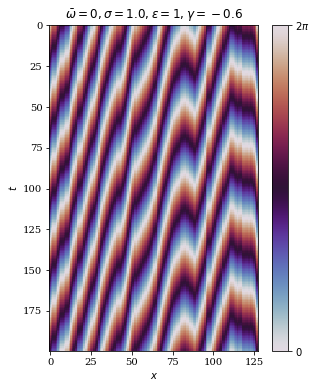

In [9]:
plt.figure(figsize=(5, 6))
plt.rc('font', size=10)
plt.rc('text', usetex=False)
im = plt.imshow(models[2].res[-200:] % (2*np.pi), cmap='twilight', interpolation='None', vmin=0, vmax=2*np.pi)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.title(r'$\bar{{\omega}}={}, \sigma={}, \epsilon ={}, \gamma ={}$'.format(mean_omega, sigma, epsilon, gamma))
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show() 

In [226]:
def find_BB(vs, gamma, grad): 
    BBs = [] 
    ds = []
    for v in vs: 
        L = len(v)+1
        m_grad = 2*np.sin(grad)/L 
        m_gamma = (2*np.sum((1-np.cos(v))) + 2*(1-np.cos(grad)))/L
        x = np.arange(1, L)
        BB = np.sin(v) - np.sin(-grad) + gamma*(1-np.cos(grad)) + gamma*(1-np.cos(v))- m_grad*x - gamma*m_gamma*x 
        BB[1:] += 2*gamma*np.cumsum(1-np.cos(v[:-1]))
        BBs.append(BB)
        
        J = np.zeros((L-1, L-1))
        diag = np.cos(v) + gamma*np.sin(v)
        np.fill_diagonal(J, diag)
        J -= gamma*2*np.outer(x, np.sin(v))/L  
        for j in range(L-1): 
            J[j+1:, j] += 2*gamma*np.sin(v[j])
        ds.append(np.abs(np.linalg.det(J)))
    return BBs, ds 

def exact_BB(omegas): 
    BBs = [] 
    for omega in omegas: 
        L = len(omega)
        x = np.arange(1, L+1)
        W = np.cumsum(omega)
        BB = (W - W[-1]*x/L)[:-1]
        BBs.append(-BB)
    return BBs 

def get_U(N): 
    M = np.tril(np.ones((N, N)))[:-1, :] - (np.arange(1, N)/N)[:, np.newaxis]
    Cov = M @ np.identity(N) @ M.T
    invCov = np.linalg.inv(Cov)
    U = np.linalg.cholesky(invCov).T 
    return U 


N = Ls[0]
M = np.tril(np.ones((N, N)))[:-1, :] - (np.arange(1, N)/N)[:, np.newaxis]
Cov = M @ np.identity(N) @ M.T 
invCov = np.linalg.inv(Cov)

def traj_logpdf(BBs): 
    BBs = np.array(BBs)
    var = 0 
    for BB in BBs: 
        var += BB.T @ invCov @ BB
    var /= BBs.size
    return var, stats.multivariate_normal.logpdf(BBs, cov=Cov*var)

def cov_zero_mean(vs): 
    return (vs.T @ vs)/vs.shape[0]
    

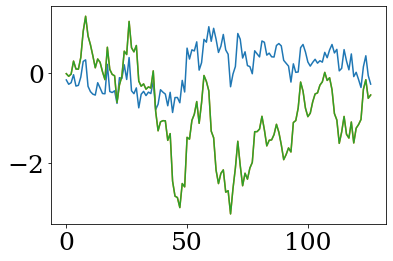

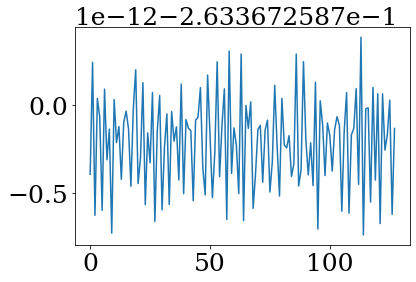

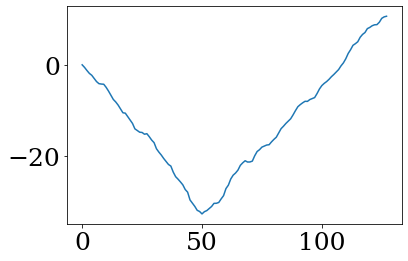

In [228]:
vs = np.array([x[1:]-x[:-1] for x in data])
vs2, dv = find_BB(vs, 0, grad)
BB, dBB = find_BB(vs, gamma, grad)
BB2 = np.array(exact_BB(omegas))
sigma = sigmas[0]

j = 4


plt.plot(vs2[j], label='v')
plt.plot(BB[j], label='BB')
plt.plot(BB2[j], label='True BB')
plt.show() 
    
model.omegas = omegas[j]
plt.plot(model._det_rhs(data[j]))
plt.show() 

plt.plot(data[j])
plt.show() 


-524.0869448847405
-524.0869448847405


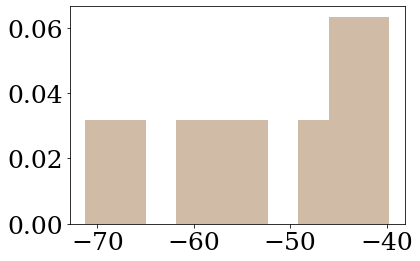

In [229]:
vs2, dv = find_BB(vs, -0.7, grad)
_, a = traj_logpdf(vs2)
ll = a + np.log(dv)
plt.hist(ll, density=True, alpha=0.3)
print(np.sum(ll))

BB, dBB = find_BB(vs, gamma, grad)
_, b = traj_logpdf(BB)
ll = b + np.log(dBB)
print(np.sum(ll))
plt.hist(ll, density=True, alpha=0.3)
plt.show()

In [ ]:
def cost(vs, gamma):
    BB, dBB = find_BB(vs, gamma, grad)
    _, b = traj_logpdf(BB)
    ll = b + np.log(dBB)
    return -np.sum(ll)

data = np.array(data)
res = MAP_gamma(data[:5])
print('gamma', res[0])
plot_cost(data)

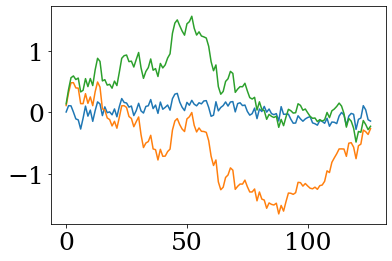

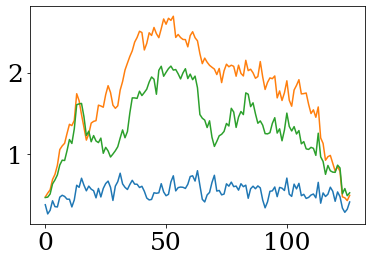

In [201]:
plt.plot(np.mean(vs2, axis=0),label='vs')
plt.plot(np.mean(BB, axis=0), label='BB1')
plt.plot(np.mean(BB2, axis=0), label='BB2')
plt.show() 

plt.plot(np.std(vs2, axis=0),label='vs')
plt.plot(np.std(BB, axis=0), label='BB1')
plt.plot(np.std(BB2, axis=0), label='BB2')
plt.show() 

-681.9094781405491
-810.0460126675804


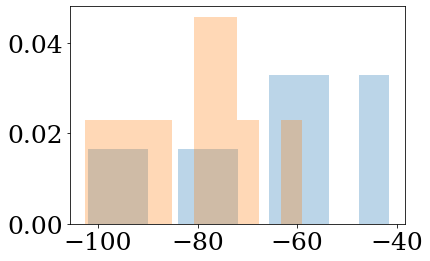

In [202]:
def lazy_logpdf(v, gamma):
    L = len(v)
    J = np.zeros((L, L))
    J += - 2*gamma/L*np.sin(v)[np.newaxis, :]
    J[0, 0] += np.cos(v[0]) + gamma*np.sin(v[0]) 
    for i in range(1, L):
        J[i, i] += np.cos(v[i]) + gamma*np.sin(v[i])
        J[i, i-1] += -np.cos(v[i-1]) + gamma*np.sin(v[i-1])
    dW = lazy_omega(v, gamma)
    sigma = np.std(dW)
    d = np.abs(np.linalg.det(J))
    return np.log(d) + np.sum(stats.norm.logpdf(dW, scale=sigma))
    
    
def lazy_omega(v, gamma): 
    v1 = np.roll(v, 1)
    Omega = 2*gamma*np.mean(1-np.cos(v))
    dW = np.sin(v) - np.sin(v1) + gamma*(1-np.cos(v1)+1-np.cos(v))-Omega
    dW[0] = np.sin(v[0]) - np.sin(-grad) + gamma*(2-np.cos(v[0])-np.cos(grad))-Omega
    return dW

logpdfs = [] 
for v in vs: 
    logpdfs.append(lazy_logpdf(v, gamma))
plt.hist(logpdfs, alpha=0.3, density=True)
print(np.sum(logpdfs))
logpdfs = [] 
for v in vs: 
    logpdfs.append(lazy_logpdf(v, 0))
print(np.sum(logpdfs))
plt.hist(logpdfs, alpha=0.3, density=True)
plt.show() 

In [203]:
plt.imshow(cov_zero_mean(vs2))
plt.colorbar() 
plt.show() 

plt.imshow(cov_zero_mean(BB))
plt.colorbar() 
plt.show() 

plt.imshow(cov_zero_mean(BB2))
plt.colorbar() 
plt.show() 

plt.imshow(Cov*sigma*sigma)
plt.colorbar() 
plt.show() 

_, bins = np.histogram(vs2.flatten(), bins=30)
weights = []
for i in range(vs2.shape[-1]):
    hist, _ = np.histogram(vs2[:, i], bins=bins)
    weights.append(hist)
    
weights = np.array(weights)
X, Y = np.meshgrid(np.arange(weights.shape[0]+1), bins)
plt.pcolor(X, Y, weights.T)
plt.plot(np.mean(vs2, axis=0), color='white')
plt.title('')
plt.show() 

_, bins = np.histogram(BB.flatten(), bins=30)
weights = []
for i in range(BB.shape[-1]):
    hist, _ = np.histogram(BB[:, i], bins=bins)
    weights.append(hist)
    
weights = np.array(weights)
X, Y = np.meshgrid(np.arange(weights.shape[0]+1), bins)
plt.pcolor(X, Y, weights.T)
plt.plot(np.mean(BB, axis=0), color='white')
plt.title('Inferred BB')
plt.show()    

_, bins = np.histogram(BB2.flatten(), bins=30)
weights = []
for i in range(BB2.shape[-1]):
    hist, _ = np.histogram(BB2[:, i], bins=bins)
    weights.append(hist)
    
weights = np.array(weights)
X, Y = np.meshgrid(np.arange(weights.shape[0]+1), bins)
plt.pcolor(X, Y, weights.T)
plt.plot(np.mean(BB2, axis=0), color='white')
plt.title('True BB')
plt.show()   

AttributeError: 'list' object has no attribute 'T'

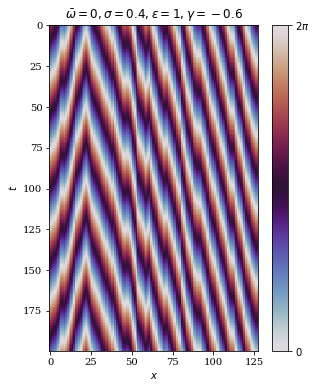

In [204]:
plt.figure(figsize=(5, 6))
plt.rc('font', size=10)
plt.rc('text', usetex=False)
im = plt.imshow(model.res[-200:] % (np.pi*2), cmap='twilight', interpolation='None', vmin=0, vmax=2*np.pi)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.title(r'$\bar{{\omega}}={}, \sigma={}, \epsilon ={}, \gamma ={}$'.format(mean_omega, sigma, epsilon, gamma))
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show() 

gamma [-0.5263158  -0.00526315]


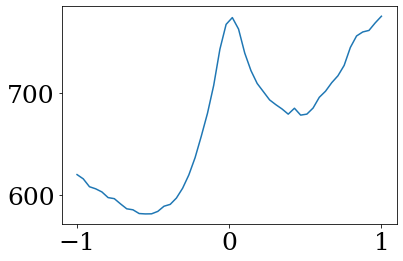

In [217]:
def cost(vs, gamma): 
    LL = 0 
    for v in vs:
        LL += lazy_logpdf(v, gamma) 
    return -LL
    
    
def to_minimise(data, gamma):
    vs = data[:, 1:] - data[:, :-1]
    return cost(vs, gamma) 
    
def MAP_gamma(data): 
    f = lambda x: to_minimise(data, x[0])+x[1]**2
    res = optimize.brute(f, ((-2, 2), (-0.1, 0.1)))
    return res

def plot_cost(data): 
    N = 50 
    gammas = np.linspace(1, -1, N)
    vs = data[:, 1:] - data[:, :-1]
    c= [] 
    for gamma in gammas: 
        c.append(cost(vs, gamma))
    plt.plot(gammas, c)
    plt.show() 
        

    



data = np.array(data)
res = MAP_gamma(data)
print('gamma', res)
plot_cost(data)